In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl as ccl
import sacc2
import sys
import datetime
from astropy.io import fits
import pickle


In [3]:
nbin = 4

In [4]:
window_ranges = [
    [5,10],
    [10,20],
    [20,30],
    [30,40],
    [40,50],
    [50, 100],
    [100, 150],
    [150, 200],
    [250, 300],
    [350, 400],
    [400, 800],
    [800, 1200],
    [1200, 1500],
    [1500, 1800],
    [1800, 2000],
    [2000, 2500],
    [2500, 3000],
]
effective_ell = [0.5*(m+M) for m,M in window_ranges]

ell_max = window_ranges[-1][-1]

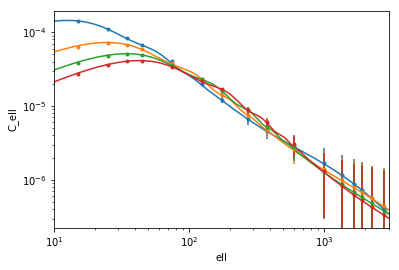

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)
N_z = []
spectra = []
errors = []
z = np.arange(0., 3.0, 0.01)
for i in range(nbin):
    mean_z = 0.3*(1+i)
    sigma_z = 0.05
    n_z = np.exp(-0.5*(z - mean_z)**2 / sigma_z**2)
    N_z.append(n_z)
    
    bias = np.ones_like(z) * 1.5*(mean_z/0.3)**0.5
    T = ccl.NumberCountsTracer(cosmo, False, (z,N_z[i]), (z, bias))
    ell = np.arange(ell_max+1)
    cl = ccl.angular_cl(cosmo, T, T, ell)
    cb = []
    for m,M in window_ranges:
        cb.append(np.mean(cl[m:M]))
    spectra.append(cb)
    errors.append(np.ones_like(cb)*1e-6)
    line, = loglog(ell, cl)
    errorbar(effective_ell, cb, yerr=errors[-1], fmt='.', color=line.get_color())
    xlim(10,3000)
    xlabel("ell")
    ylabel("C_ell")

    

In [6]:
S = sacc2.Sacc()

S.metadata['nbin_lens'] = 4
S.metadata['nbin_source'] = 0 
S.metadata['creator'] = 'Beloved User'
S.metadata['creation'] = datetime.datetime.now().isoformat()
S.metadata['info'] = 'Theory predictions using CCL'

# In this case we use the same top-hat window for each bin.
# In reality we would probably use a different window for each
# pair of bins, empirically determined.
windows = [sacc2.TopHatWindow(m,M) for m,M in window_ranges]

# Imaginary new statistic's window that I just made up
windows_1pt = []
for i in range(5):
    v = np.arange(i*10., (i+1)*10.)
    w = np.random.uniform(size=10)**2
    windows_1pt.append(sacc2.Window(v,w))

variances = []
for i in range(nbin):
    # Add the appropriate tracer
    S.add_tracer('NZ', f'bin_{i}', z, N_z[i])
    # Get the binned spectrum values
    cb = spectra[i]
    # In this case we are just doing LSS, so
    # there is just a single bin, repeated.
    bin_name = f'bin_{i}'
    # Add the values
    S.add_ell_cl('galaxy_density_cl', bin_name, bin_name, effective_ell, cb, window=windows)
    variances.append(errors[i])
    # Imaginary statistic to test having a second kind of data here
    for i in range(10):
        S.add_data_point('galaxy_density_1pt', (bin_name,), 1.0*np.sqrt(i),
                         window=windows_1pt[i%5], is_good=np.random.choice([0,1]))
        variances.append([1.0])

S.add_covariance(np.concatenate(variances))

# The canonical ordering organizes things by data type
S.to_canonical_order()


/Users/jaz/src/Sacc/sacc2/sacc.py:41: UserWarning: Unknown data_type value galaxy_density_1pt. If possible use a pre-defined type.
  warnings.warn(f"Unknown data_type value {data_type}. If possible use a pre-defined type.")


In [8]:
S.to_pickle('tmp.dat', overwrite=True)
S2 = sacc2.Sacc.from_pickle('tmp.dat')

/Users/jaz/src/Sacc/sacc2/sacc.py:41: UserWarning: Unknown data_type value galaxy_density_1pt. If possible use a pre-defined type.
  warnings.warn(f"Unknown data_type value {data_type}. If possible use a pre-defined type.")


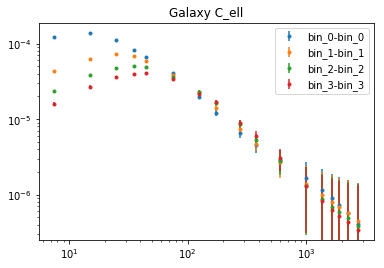

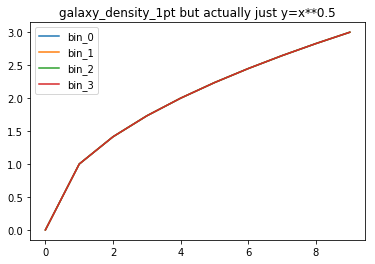

In [9]:
#plot our other kind of weird pretend statistic
for b1, b2 in S2.get_tracer_combinations('galaxy_density_cl'):
    ell, cl, covmat = S2.get_ell_cl('galaxy_density_cl', b1, b2, return_cov=True)
    errorbar(ell, cl, yerr=covmat.diagonal(), fmt='.', label=f'{b1}-{b2}')
    xscale('log')
    yscale('log')
title("Galaxy C_ell")
legend()

figure()
#plot our other kind of weird pretend statistic
for tracers in S2.get_tracer_combinations('galaxy_density_1pt'):
    mu = S2.get_mean('galaxy_density_1pt', tracers)
    plot(mu, label=str(tracers[0]))
title("galaxy_density_1pt but actually just y=x**0.5")
legend()